# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, accuracy_score, roc_auc_score, auc
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.utils import shuffle
from sklearn.feature_selection import VarianceThreshold, SelectFromModel

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [3]:
PATH = "./data/"

In [4]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')
test_insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'test.csv')).set_index('id')

In [5]:
insurance_data.columns

Index(['target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      

Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [6]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [7]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [10]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

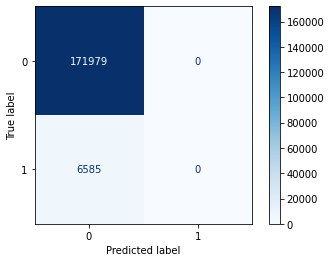

In [11]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [12]:
insurance_data.describe()


,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

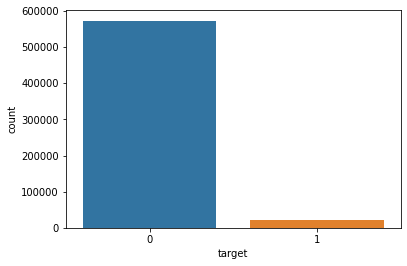

In [13]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [14]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float64)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return (gini_sum) / (len(actual))  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    adiv = (gini(a, p)) / (gini(a, a))
    return adiv

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

The ROC graph summarizes all of the confusion matrices that each threshold produced.
AUC area under the ROC graph. It makes comparision of one ROC curve to another easy. The bigger AUC is, the better is the ROC curve plotted depending on a chosen threshold.
I will create plot for visualization of ROC and Gini lines. I addition, numerical check will be done afterwards.

The size of region under our ROC curve is (AUC):  0.6279361790843572


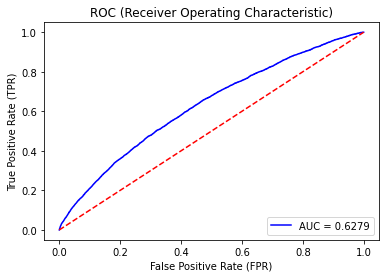

In [15]:
fpr, tpr, thresholds = metrics.roc_curve(y_valid, clf.predict_proba(X_valid)[:, 1])
metrics_auc = metrics.auc(fpr, tpr)
print('The size of region under our ROC curve is (AUC): ', metrics_auc)

plt.title('ROC (Receiver Operating Characteristic)')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.4f'% metrics_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.show()

In [16]:
# proof of Normalized Gini Coefficient = 2 x AUC - 1 in numbers
auc_score = 2*metrics_auc - 1
GINI = gini_normalized(y_valid, clf.predict_proba(X_valid)[:, 1])
print(f' gini = {GINI} \n 2 x AUC - 1: {auc_score}')


 gini = 0.2558723581569817 
 2 x AUC - 1: 0.25587235816871434


Observations show that the *2 x AUC - 1* very close to Normalized Gini Coefficient (to 10 decimal points)

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

As long as we have highly imbalanced dataset, through my observations, using metrics would be a good fit for our dataset.

1. Threshold (e.g., accuracy and F-measure) - easy to calculate and easy to understand.
2. Ranking (e.g., receiver operating characteristics (ROC) analysis and AUC) - don’t make any assumptions about class distributions, more concerned with evaluating classifiers based on how effective they are at separating classes.
3. Probabilistic (e.g., root-mean-squared error) - requires that the probabilities are calibrated. In this dataset it may need us more work to balance the values for using this metrics in training.

Because of their behavior working best with highly imbalanced datatest, these metrics provide effective prediction of classes and labels.

Let's calculate the Normalized Gini Coefficient:

In [17]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [18]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [19]:
## your code

Will use two methods of widely adopted technique - Resampling.


1. Under-sampling (removes random records from multiple classes, information loss may occur)
2. Over-sampling (causes over-fitting because a few classes replicate random records (rows))

#### 1. Under-sampling

In [20]:
class_0_count, class_1_count = insurance_data.target.value_counts()

class_0, class_1 = insurance_data[insurance_data['target'] == 0],insurance_data[insurance_data['target'] == 1]
print(f' class_0_count: {class_0_count} \n class_1_count: {class_1_count}')

 class_0_count: 573518 
 class_1_count: 21694


In [21]:
df_class_0_under = class_0.sample(n=class_1_count)
df_test_under = pd.concat([df_class_0_under, class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

Random under-sampling:
0    21694
1    21694
Name: target, dtype: int64


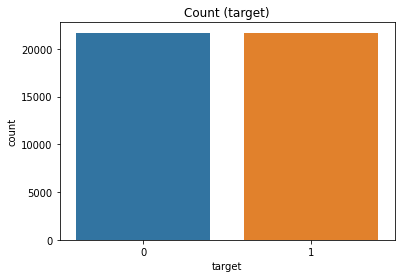

In [22]:
sns.countplot(x=df_test_under['target'])
plt.title('Count (target)')
plt.show()

#### 2. Over-sampling

In [23]:
df_class_1_over = class_1.sample(class_0_count, replace=True)
df_test_over = pd.concat([class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())

print('Before dummification we have {} variables in train'.format(insurance_data.shape[1]))
print('Before dummification we have {} variables in test'.format(test_insurance_data.shape[1]))

Random over-sampling:
0    573518
1    573518
Name: target, dtype: int64
Before dummification we have 58 variables in train
Before dummification we have 57 variables in test


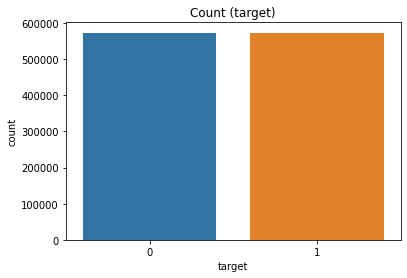

In [24]:
sns.countplot(x=df_test_over['target'])
plt.title('Count (target)')
plt.show()

Conclusion on choice of Resampling technique:

Both techniques are giving same results, because we already got rid of dummy values in preceding steps.


Since we are using a large training set, we use undersampling.

Printing the the rate of missing values to evaluate the % and to do feature selection later 

In [25]:
ntrain, ntest = insurance_data.shape[0], test_insurance_data.shape[0]
y_train = insurance_data.target.values

vars_with_missing = []

for f in insurance_data.columns:
    missing = insurance_data[insurance_data[f] == -1][f].count()
    if missing > 0:
        vars_with_missing.append(f)
        missing_perc = missing / insurance_data.shape[0]

        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missing, missing_perc))

print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
In total, there are 13 variables with missing values


ps_car_03_cat, ps_car_05_cat: Too many missing values are erased.

For other categorical data with missing values, you can leave the missing value -1.

ps_reg_03 (continuous): There are 18% missing values. Fill it with the average.

ps_car_11 (ordinal): There are 5 missing values. Fill it with the mode.
ps_car_12 (continuous): There are 2 missing values. Fill it with the average.
ps_car_14 (continuous): There are 7% missing values. Fill it with the average.

In [26]:
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
insurance_data.drop(vars_to_drop, inplace=True, axis=1)
test_insurance_data.drop(vars_to_drop, inplace=True, axis=1)

#### Feature Engineering

Mean-encoding for variables with many unique values were .
For the remaining variables, dummy variables are created. (one-hot endcoding)

#### Feature Selection

Will be removing features with zero variance or small variance

In [35]:
selector = VarianceThreshold(threshold=0.01)
selector.fit(insurance_data.drop(['target'], axis=1))
cols = ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin','ps_car_10_cat', 'ps_car_12']
print('{} variables have too low variance.'.format(len(cols)))
print('These variables are {}'.format(list(cols)))

6 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_10_cat', 'ps_car_12']


#### Selecting features with a Random Forest and SelectFromModel

In [30]:
test_insurance_data = test_insurance_data.rename_axis('id').reset_index()
id_test = test_insurance_data['id']

In [36]:
selector.fit(test_insurance_data.drop(['id'], axis=1))
cols = ['for test: ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin','ps_car_10_cat', 'ps_car_12']
print('{} variables have too low variance.'.format(len(cols)))
print('These variables are {}'.format(list(cols)))

6 variables have too low variance.
These variables are ['for test: ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_10_cat', 'ps_car_12']


In [31]:
X_train = insurance_data.drop('target', axis=1)
y_train = insurance_data['target']

test_insurance_data
id_test = test_insurance_data['id']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

 1) ps_car_13                      0.060155
 2) ps_reg_03                      0.052959
 3) ps_car_14                      0.042032
 4) ps_calc_10                     0.038171
 5) ps_calc_14                     0.037651
 6) ps_calc_11                     0.035723
 7) ps_ind_15                      0.032723
 8) ps_car_11_cat                  0.032464
 9) ps_ind_03                      0.031993
10) ps_calc_01                     0.031795
11) ps_calc_02                     0.031664
12) ps_calc_03                     0.031662
13) ps_calc_13                     0.030221
14) ps_reg_02                      0.030012
15) ps_calc_08                     0.028683
16) ps_calc_07                     0.028598
17) ps_calc_06                     0.026887
18) ps_calc_09                     0.026102
19) ps_car_15                      0.025953
20) ps_calc_05                     0.024654
21) ps_calc_04                     0.024435
22) ps_ind_01                      0.024276
23) ps_car_06_cat               

In [72]:
X_test = test_insurance_data.values

df = pd.DataFrame()
df['id'] = id_test
df['target'] = rf.predict(X_test[:, :-1])
df.set_index('id')

,target
id,
0,0
1,0
2,0
3,0
4,0
...,...
1488022,0
1488023,0
1488024,0


In [73]:
df

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
892811,1488022,0
892812,1488023,0
892813,1488024,0
892814,1488025,0


In [71]:
df.to_csv('submission.csv', index=False)

Kaggle score

![kaggle score](./kaggle-score-task5.png)

Please, note that it's my first practice with imbalanced dataset and using Randomfor